# Image Segmentation with U-Net

## 1 - Packages

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Conv2DTranspose,
    concatenate
)
from test_utils import summary, comparator


2025-01-05 07:46:01.274637: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 07:46:01.275014: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-05 07:46:01.276835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-05 07:46:01.282096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736045161.290696    5633 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736045161.29

## 2 - Load and Splite the Data

In [5]:
import os
import pandas as pd  # Data processing, e.g., reading CSV files
import imageio
import matplotlib.pyplot as plt

# Ensure matplotlib inline mode for Jupyter notebooks
# This line is unnecessary in a script and specific to Jupyter; remove it if unused
# %matplotlib inline

# Define paths for images and masks
data_dir = './data'
image_dir = os.path.join(data_dir, 'CameraRGB')
mask_dir = os.path.join(data_dir, 'CameraMask')

# List and create full paths for images and masks
image_list = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
mask_list = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]


In [6]:
# Get the total number of images
len(image_list)

850

### Check out the some of the unmasked and masked images from the dataset:

/tmp/ipykernel_5633/601820560.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])  # Read the image
/tmp/ipykernel_5633/601820560.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])  # Read the mask


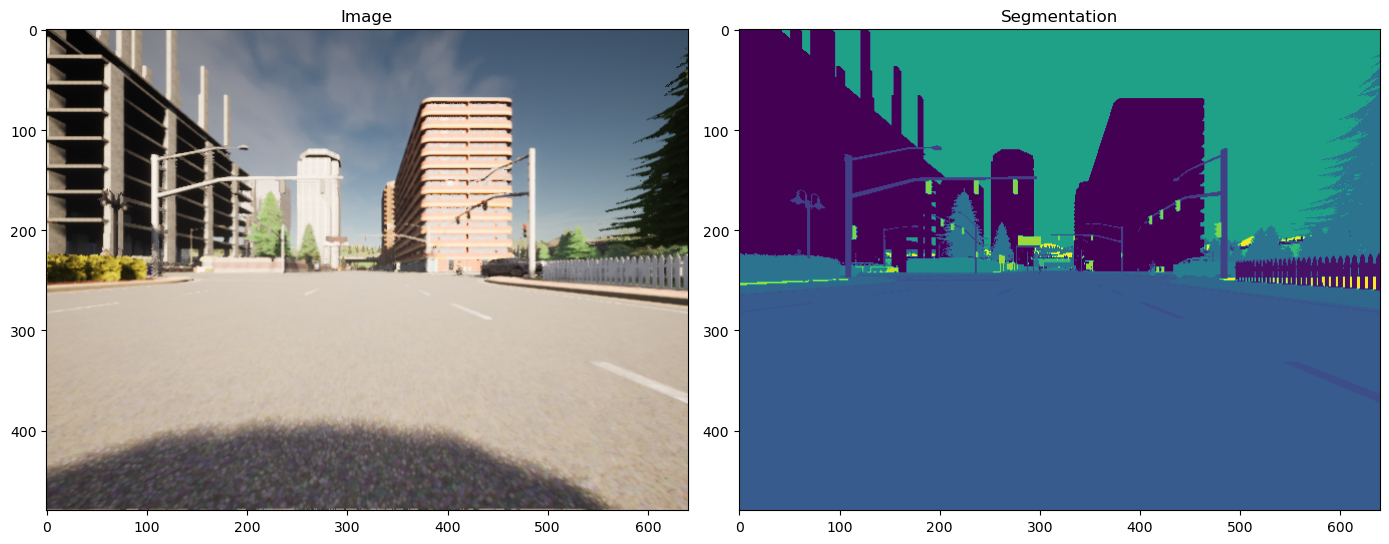

In [8]:
# Display an image and its corresponding mask
N = 1  # Index of the image to display
img = imageio.imread(image_list[N])  # Read the image
mask = imageio.imread(mask_list[N])  # Read the mask

# Plot the image and the segmentation mask
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')

# Display the first channel of the mask if it has multiple channels
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

# Optional: Adjust layout for better visualization
plt.tight_layout()
plt.show()

### 2.1 - Split Your dataset into Unmasked and Masked Images

In [10]:
# Create TensorFlow datasets for images and masks by listing file paths
image_list_ds = tf.data.Dataset.from_tensor_slices(image_list)
mask_list_ds = tf.data.Dataset.from_tensor_slices(mask_list)

# Use the `zip` function to pair image and mask paths, and print the first 3 pairs
for image_path, mask_path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(image_path.numpy(), mask_path.numpy())  # Convert tensors to NumPy for readable paths


b'./data/CameraRGB/012504.png' b'./data/CameraMask/012504.png'
b'./data/CameraRGB/010578.png' b'./data/CameraMask/010578.png'
b'./data/CameraRGB/049164.png' b'./data/CameraMask/049164.png'


W0000 00:00:1736045164.047106    5633 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-01-05 07:46:04.073934: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Convert lists of image and mask filenames into TensorFlow constants
image_filenames = tf.constant(image_list)
mask_filenames = tf.constant(mask_list)

# Create a TensorFlow dataset from paired image and mask filenames
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))

# Print the first image and mask pair from the dataset
for image, mask in dataset.take(1):
    print(image.numpy())  # Convert tensor to NumPy array for display
    print(mask.numpy())   # Convert tensor to NumPy array for display


b'./data/CameraRGB/012504.png'
b'./data/CameraMask/012504.png'


2025-01-05 07:46:04.081263: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 2.2 - Preprocess Your Data

In [13]:
def process_path(image_path, mask_path):
    """
    Reads and decodes image and mask files, converting them to the required formats.
    - Converts image to float32 and mask to a single channel (grayscale).
    """
    # Read and decode the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)  # Decode as RGB image
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float32 for further processing

    # Read and decode the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)  # Decode as RGB mask
    mask = tf.reduce_max(mask, axis=-1, keepdims=True)  # Convert mask to a single channel (grayscale)
    
    return img, mask


def preprocess(image, mask):
    """
    Resizes image and mask to fixed dimensions and normalizes the image.
    """
    # Resize both the image and the mask
    image_resized = tf.image.resize(image, (96, 128), method='nearest')  # Resize image using nearest neighbor
    mask_resized = tf.image.resize(mask, (96, 128), method='nearest')  # Resize mask using nearest neighbor
    
    # Normalize the image values to [0, 1]
    image_resized = image_resized / 255.0
    
    return image_resized, mask_resized


# Apply the functions to the dataset using the map method
image_ds = dataset.map(process_path)  # Apply process_path to each pair of image and mask paths
processed_image_ds = image_ds.map(preprocess)  # Apply preprocess to resize and normalize images and masks


## 3 - U-Net

### 3.1 - Model Details

#### contracting path

#### crop function

#### Expanding path

#### Final Feature Mapping Block

### 3.2 - Encoder (Downsampling Block)

In [21]:
def conv_block(inputs, n_filters=32, dropout_prob=0.0, max_pooling=True):
    """
    Creates a convolutional block with two Conv2D layers, optional Dropout, and optional MaxPooling2D.
    
    Arguments:
        inputs: Input tensor for the block.
        n_filters: Number of filters for the Conv2D layers (default: 32).
        dropout_prob: Dropout probability (default: 0.0). If 0, no Dropout is applied.
        max_pooling: Boolean indicating whether to apply MaxPooling2D (default: True).
        
    Returns:
        next_layer: The output tensor of the block (after MaxPooling2D if applied).
        skip_connection: The output tensor before MaxPooling2D, used for skip connections.
    """
    # First convolutional layer with ReLU activation, same padding, and He-normal initialization
    conv = Conv2D(
        filters=n_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal'
    )(inputs)
    
    # Second convolutional layer with similar settings
    conv = Conv2D(
        filters=n_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal'
    )(conv)
    
    # Apply Dropout if a positive dropout probability is specified
    if dropout_prob > 0.0:
        conv = Dropout(rate=dropout_prob)(conv)
    
    # Apply MaxPooling2D if specified, else pass through the convolutional layers unchanged
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=2, strides=2)(conv)
    else:
        next_layer = conv
    
    # Save the output before MaxPooling for use as a skip connection
    skip_connection = conv
    
    return next_layer, skip_connection


In [22]:
# # Define the input size and base number of filters
# input_size = (96, 128, 3)
# n_filters = 32

# # Create a model using the first convolutional block (cblock1)
# inputs = Input(shape=input_size)
# cblock1 = conv_block(inputs, n_filters)
# model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

# # Expected summary of the first model for comparison
# output1 = [
#     ['InputLayer', [(None, 96, 128, 3)], 0],
#     ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
#     ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
#     ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
# ]

# print('Block 1:')
# # Print the summary of the first model
# for layer in summary(model1):
#     print(layer)

# # Compare the actual summary with the expected output
# comparator(summary(model1), output1)

# # Create a model using the second convolutional block (cblock2) with additional configurations
# inputs = Input(shape=input_size)
# cblock2 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
# model2 = tf.keras.Model(inputs=inputs, outputs=cblock2)

# # Expected summary of the second model for comparison
# output2 = [
#     ['InputLayer', [(None, 96, 128, 3)], 0],
#     ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
#     ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
#     ['Dropout', (None, 96, 128, 1024), 0, 0.1],
#     ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
# ]

# print('\nBlock 2:')
# # Print the summary of the second model
# for layer in summary(model2):
#     print(layer)

# # Compare the actual summary with the expected output
# comparator(summary(model2), output2)


### 3.3 - Decoder (Upsampling Block)

### upsampling_block

In [25]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Creates a convolutional upsampling block for a U-Net-like architecture.

    Arguments:
        expansive_input -- Input tensor from the expansive path (upward path)
        contractive_input -- Input tensor from the contractive path (downward path)
        n_filters -- Number of filters for the convolutional layers (default is 32)

    Returns:
        conv -- Output tensor after upsampling and convolution operations
    """
    
    # Upsample using Conv2DTranspose (also known as transposed convolution)
    up = Conv2DTranspose(
        filters=n_filters,  # Number of filters for the upsampling
        kernel_size=3,  # Kernel size (height and width)
        strides=2,  # Upsampling factor
        padding='same'  # Ensure output size matches the input
    )(expansive_input)

    # Concatenate the upsampled tensor with the skip connection (contractive input)
    merge = concatenate([up, contractive_input], axis=-1)  # Concatenate along the channel axis
    
    # Apply two 3x3 convolutions to process the concatenated tensor
    conv = Conv2D(
        filters=n_filters,
        kernel_size=3,
        activation='relu',
        padding='same',  # Maintain the same spatial dimensions
        kernel_initializer='he_normal'  # He normal initializer for weights
    )(merge)
    
    conv = Conv2D(
        filters=n_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal'
    )(conv)

    return conv


In [26]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2DTranspose, Conv2D, concatenate
# from tensorflow.keras.models import Model

# # Define the input sizes for expansive and contractive paths
# input_size1 = (12, 16, 256)
# input_size2 = (24, 32, 128)
# n_filters = 32

# # Create input layers for both expansive and contractive paths
# expansive_inputs = Input(shape=input_size1)
# contractive_inputs = Input(shape=input_size2)

# # Create the upsampling block
# cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)

# # Define the model with two inputs (expansive and contractive) and one output (upsampled block)
# model1 = Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

# # Expected output after applying the 'summary' function
# output1 = [
#     ['InputLayer', [(None, 12, 16, 256)], 0],
#     ['Conv2DTranspose', (None, 24, 32, 32), 73760],
#     ['InputLayer', [(None, 24, 32, 128)], 0],
#     ['Concatenate', (None, 24, 32, 160), 0],
#     ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
#     ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
# ]

# # Print the summary for Block 1
# print('Block 1:')
# for layer in summary(model1):  # Display the model summary
#     print(layer)

# # Compare the generated summary with the expected output
# comparator(summary(model1), output1)


### 3.4 - Build the Model

In [28]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    U-Net model for semantic segmentation.

    Args:
        input_size (tuple): Shape of the input tensor (height, width, channels).
        n_filters (int): Base number of filters for the convolutional layers.
        n_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: Compiled U-Net model.
    """

    # Input layer
    inputs = Input(shape=input_size)

    # Contracting Path (Encoder)
    # Each conv_block doubles the filters at each step.
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters * 1)  # Block 1
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters * 2)  # Block 2
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters * 4)  # Block 3
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters * 8, dropout_prob=0.3)  # Block 4 with Dropout
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters * 16, dropout_prob=0.3, max_pooling=False)  # Block 5 (no MaxPooling)

    # Expanding Path (Decoder)
    # Each upsampling_block halves the filters at each step.
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)  # Block 6
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)  # Block 7
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)  # Block 8
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters * 1)  # Block 9

    # Final Convolution Layers
    # Conv9 applies additional convolution to refine features.
    conv9 = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)

    # Conv10 generates the final output with n_classes.
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation='softmax')(conv9)

    # Model Definition
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [29]:
# from tensorflow.keras.utils import plot_model
# import outputs
# # Image input dimensions
# img_height = 96
# img_width = 128
# num_channels = 3

# # Initialize the U-Net model with the specified input size
# unet = unet_model((img_height, img_width, num_channels))

# # Generate the model's summary and compare it with the expected output
# model_summary = summary(unet)  # Assumes `summary` is defined to return the model's structure
# comparator(model_summary, outputs.unet_model_output)

# # Optional: Save the model visualization to a file for better understanding
# plot_model(unet, to_file="unet_model.png", show_shapes=True, show_layer_names=True)


### 3.5 - Set Model Dimensions

In [31]:
# Define the input dimensions for the model
img_height = 96  # Height of the input image
img_width = 128  # Width of the input image
num_channels = 3  # Number of color channels (3 for RGB)

# Instantiate the U-Net model with the given input size
unet = unet_model(input_size=(img_height, img_width, num_channels))


### Check out the model summary below!

In [33]:
# Display a summary of the model to verify its structure
unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 128,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 128,   │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 8, 256) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 6, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 6, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 6, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 12, 16,    │  1,179,904 │ dropout_1[0][0] 

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

### 3.6 - Loss Function

In [35]:
# Compile the U-Net model
unet.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Use the Adam optimizer for adaptive learning rates
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
    # SparseCategoricalCrossentropy is used for integer-encoded labels (not one-hot encoded)
    metrics=['accuracy']  # Track accuracy during training and evaluation
)


### 3.7 - Dataset Handling

In [37]:
def display(display_list):
    """
    Display a list of images with their corresponding titles.

    Args:
        display_list (list): A list of images to display. The list should contain:
                             - Input image
                             - True mask
                             - Predicted mask
    """
    import matplotlib.pyplot as plt  # Ensures the required library is imported in this function's scope
    
    plt.figure(figsize=(15, 15))  # Set the figure size for better visualization
    
    # Titles corresponding to the images
    titles = ['Input Image', 'True Mask', 'Predicted Mask']

    # Loop through the images and titles, displaying each
    for i, image in enumerate(display_list):
        plt.subplot(1, len(display_list), i + 1)  # Arrange images in a single row
        plt.title(titles[i])  # Set the title for the image
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image))  # Convert and display the image
        plt.axis('off')  # Hide axes for better presentation
    
    plt.show()  # Display the figure


Mask shape: (480, 640, 1)


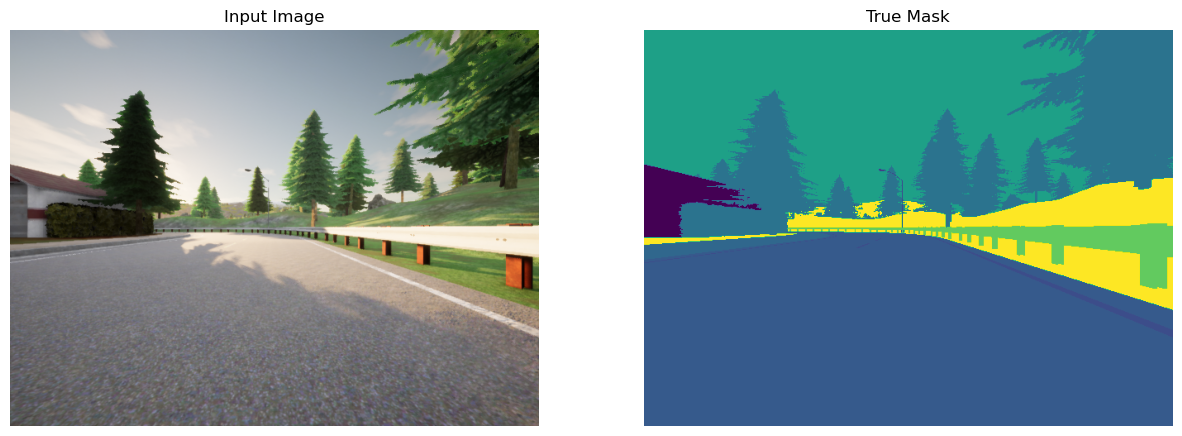

In [38]:
# Iterate through the dataset to extract a single image and its corresponding mask
for image, mask in image_ds.take(1):
    # Assign the first image and mask to variables for display
    sample_image, sample_mask = image, mask
    
    # Print the shape of the mask to confirm its dimensions
    print(f"Mask shape: {mask.shape}")

# Use the display function to visualize the input image and its corresponding mask
display([sample_image, sample_mask])


Mask shape: (96, 128, 1)


2025-01-05 07:46:04.546812: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


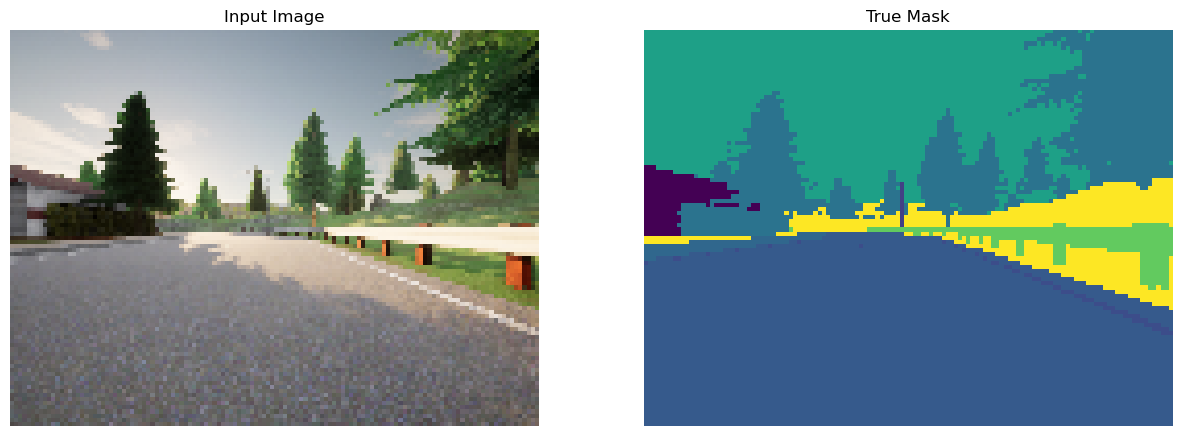

In [39]:
# Extract a single image and its corresponding mask from the processed dataset
for sample_image, sample_mask in processed_image_ds.take(1):
    # Print the shape of the mask for verification
    print(f"Mask shape: {sample_mask.shape}")

# Visualize the input image and its corresponding mask using the display function
display([sample_image, sample_mask])


## 4 - Train the Model

In [41]:
# Configuration constants
EPOCHS = 40  # Number of training epochs
BUFFER_SIZE = 500  # Buffer size for shuffling the dataset
BATCH_SIZE = 32  # Batch size for training

# Preprocess the dataset
# - Cache the dataset for faster access during training
# - Shuffle the dataset with the specified buffer size
# - Batch the dataset into smaller chunks for efficient processing
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Print the structure of dataset elements for verification
print(f"Dataset structure: {processed_image_ds.element_spec}")

# Train the U-Net model
# - The dataset is iterated over for the specified number of epochs
model_history = unet.fit(train_dataset, epochs=EPOCHS)


Dataset structure: (TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40


/home/muhammad-saqib/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3334 - loss: 3.2479
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3907 - loss: 1.9638
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5664 - loss: 1.3301
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7538 - loss: 0.9126
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7612 - loss: 0.7908
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7722 - loss: 0.7518
Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7868 - loss: 0.6970
Epoch 8/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8009 - loss: 0.6559
Epoch 9/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8093 - loss: 0.6153
Epoch 10/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8184 - loss: 0.5791
Epoch 11/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8269 - loss: 0.5505
Epoch 12/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8439 - loss: 0.4910


### 4.1 - Create Predicted Masks

In [43]:
def create_mask(pred_mask):
    """
    Creates a predicted mask by extracting the class with the highest probability 
    from the model's output.

    Args:
        pred_mask: The predicted output tensor from the model 
                   (typically of shape [batch_size, height, width, num_classes]).

    Returns:
        A single mask of shape [height, width, 1] representing the class index 
        with the highest probability for each pixel.
    """
    # Extract the index of the maximum probability along the last axis (class axis)
    pred_mask = tf.argmax(pred_mask, axis=-1)

    # Add a new axis to maintain compatibility with expected image dimensions [height, width, 1]
    pred_mask = pred_mask[..., tf.newaxis]

    # Return the first mask in the batch (assuming batch size > 1)
    return pred_mask[0]


### 4.3 - Plot Model Accuracy

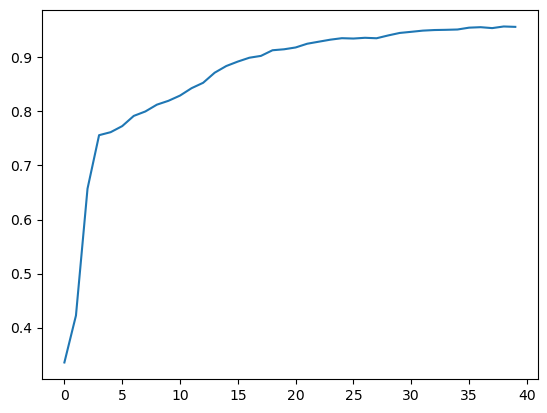

In [45]:
# Plot the accuracy values recorded during training across epochs
plt.plot(model_history.history["accuracy"])


### 4.3 - Show Predictions

In [47]:
def show_predictions(dataset=None, num=1):
    """
    Displays the predictions for the specified number of samples from the dataset.
    If no dataset is provided, displays the prediction for a predefined sample image.
    
    Parameters:
        dataset (tf.data.Dataset): A dataset containing image and mask pairs. Defaults to None.
        num (int): The number of predictions to display from the dataset. Defaults to 1.
    """
    if dataset:
        # Iterate through the dataset and display predictions for the specified number of samples
        for image, mask in dataset.take(num):
            # Generate predicted mask using the model
            pred_mask = unet.predict(image)
            # Display the input image, true mask, and predicted mask
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        # Display predictions for a predefined sample image if no dataset is provided
        display([
            sample_image,  # Input image
            sample_mask,   # True mask
            create_mask(unet.predict(sample_image[tf.newaxis, ...]))  # Predicted mask
        ])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


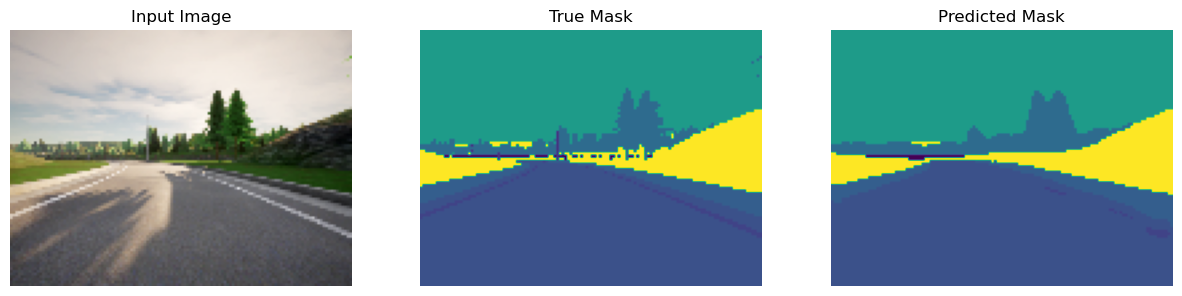

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


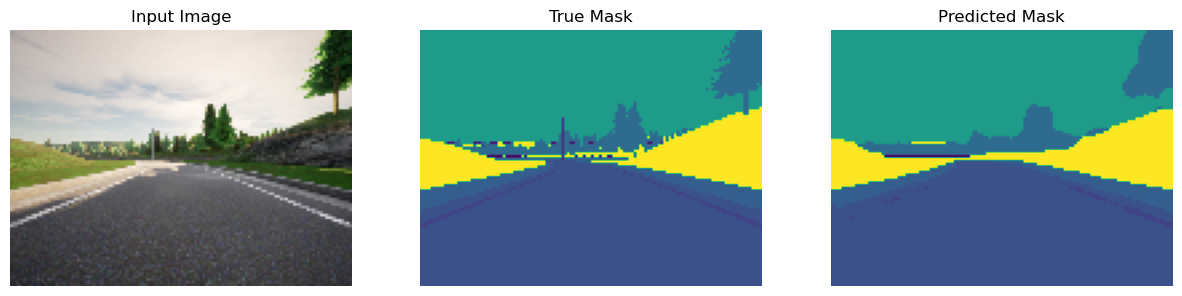

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


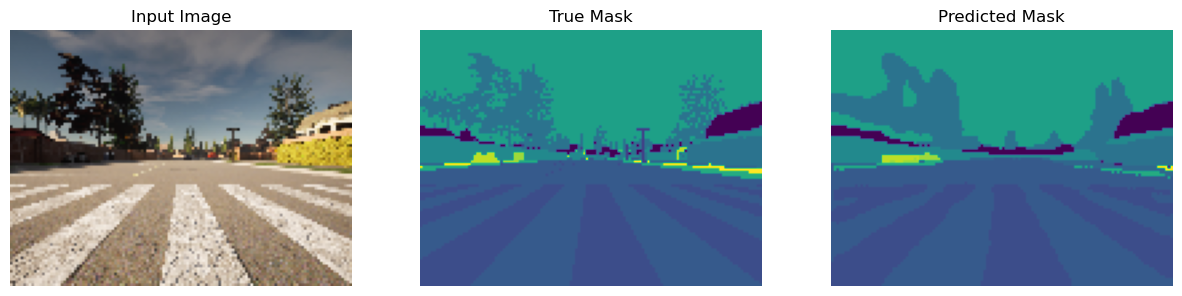

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


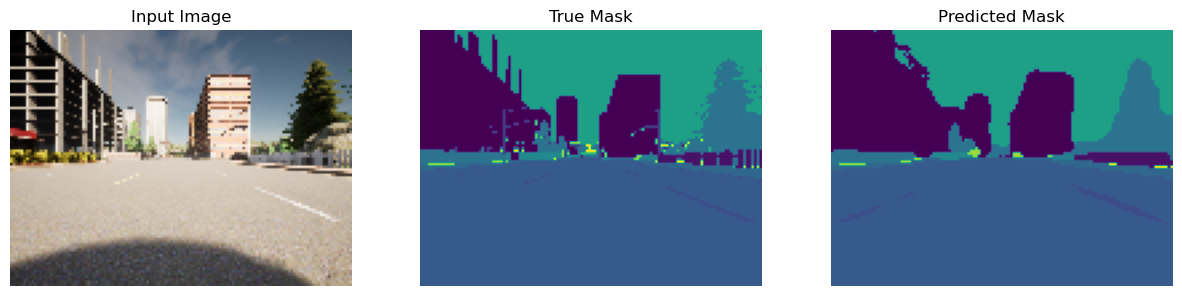

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


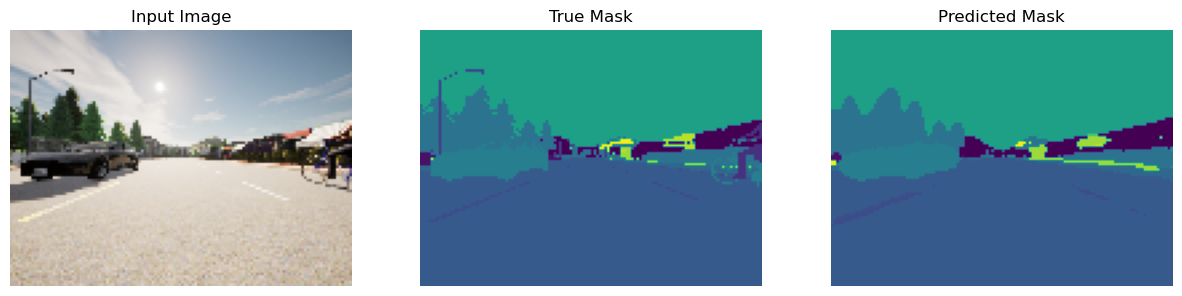

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


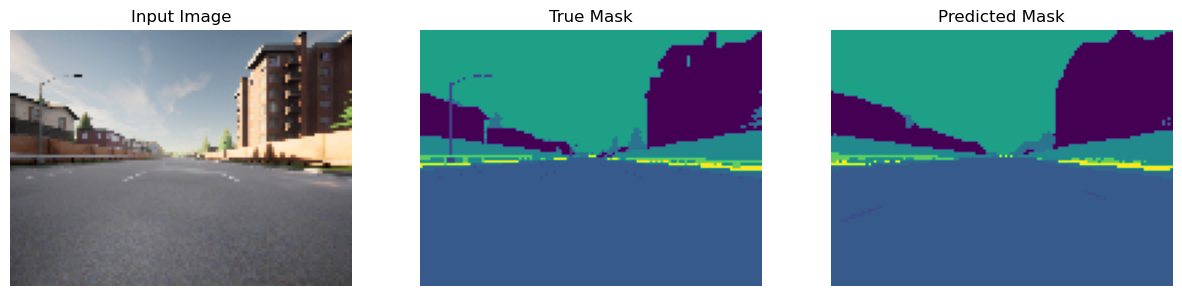

In [48]:
# Display predictions for 6 samples from the train_dataset
show_predictions(train_dataset, 6)
